# Introduction to Data Science – Homework 8
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, April 3, 11:59pm.

In this homework, you will use clustering, principal component analysis, regular expressions, and natural language processing. 

## Your Data
First Name: Elizabeth
<br>
Last Name: Maynard
<br>
E-mail: Liz.r.maynard@gmail.com
<br>
UID: u1194394
<br>

In [2]:
# imports and setup 

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA 

import nltk
from nltk.corpus import stopwords

import re

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

## Part 1: Analyze US Crime data

We'll analyze a dataset describing 1973 violent crime rates by US State. The crimes considered are assault, murder, and rape. Also included is the percent of the population living in urban areas.

The dataset is available as *USarrests.csv*. The dataset has 50 observations (corresponding to each state) on 4 variables: 
1. Murder: Murder arrests (per 100,000 residents)
2. Assault: Assault arrests (per 100,000 residents)
3. UrbanPop: Percent urban population
4. Rape: Rape arrests (per 100,000 residents)


You can read more about the dataset [here](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/USArrests.html). 

Our goal will be to use unsupervised methods to understand how violent crimes differ between states. 

### Task 1.1 Import the data and perform some preliminary exploratory analysis. 
Use the *read_csv* pandas function to import the data as a dataframe. 

Plot a scatterplot matrix of the data. Explore basic statistics of the data. Write a few sentences describing how the variables are correlated. 

In [27]:
# Your code here
arrests = pd.read_csv("USarrests.csv")
arrests.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


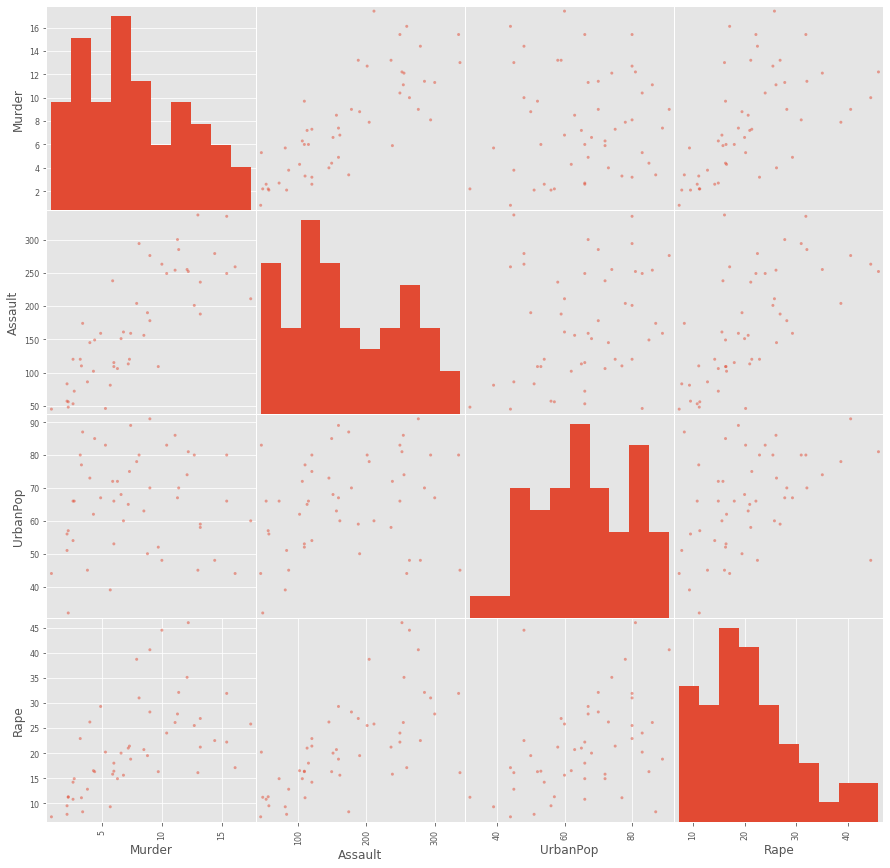

In [3]:
from pandas.plotting import scatter_matrix
colset = arrests
scatter_matrix(colset, alpha=0.5, figsize=(15, 15))
print()

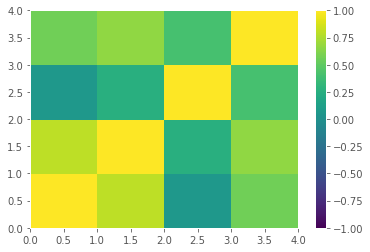

In [4]:
correl = arrests.corr()
correlplot = plt.pcolor(correl, vmin=-1, vmax=1)
plt.colorbar()

**Your description:** There's a correlation between Assault and Murder and between Rape and Assault. There is also somewhat of a correlation betwen UrbanPop and Rape. The lowest correlation is between UrbanPop and Murder.


### Task 1.2 - Cluster Heat Map

Generate a [cluster heat map](https://seaborn.pydata.org/generated/seaborn.clustermap.html) with a dendrogram using seaborn (see lecture). Be sure to standardize the dataset using the `standard_scale=1` parameter.

Describe any patterns you see.

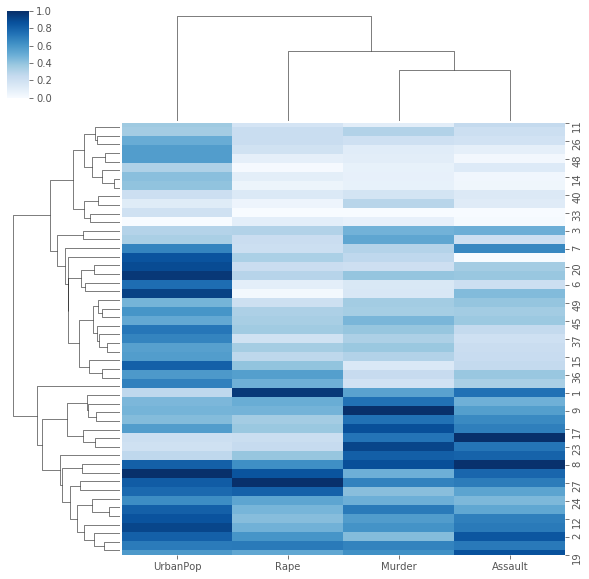

In [28]:
# your code here 
PCframe2 = pd.DataFrame({"Murder": arrests["Murder"], 
                            "Assault": arrests["Assault"],"UrbanPop": arrests["UrbanPop"],
                       "Rape": arrests["Rape"]})
g = sns.clustermap(PCframe2, method="average", metric="euclidean", cmap="Blues",standard_scale=1)

**Your Interpretation**: Low Urban Pupolations tend to have less Rape, and places with high Murder rates have high Assault Rates as well.

### Task 1.3 Visualize the data using PCA

Complete the following steps:
1. Scale the dataset using the *scale* function of the sklearn.preprocessing library. *check*
+ Calculate the principal components of the dataset. *check*
+  Store the principal components in a pandas dataframe. *check*
+ Plot a scatterplot of PC1 and PC2. Using the matplotlib function *annotate*, use the state names as markers (instead of dots).
+ Print the explained variance ratio of the PCA. Plot the explained variance ratio of the PCA. Interpret these values. Is it reasonable to reduce the four dimensional space to two dimensions using PCA? 

In [43]:
# your code here
PCframe = pd.DataFrame({"State": arrests["Unnamed: 0"],
                         "Murder": arrests["Murder"], 
                            "Assault": arrests["Assault"],"UrbanPop": arrests["UrbanPop"],
                       "Rape": arrests["Rape"]})
PCframe.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [44]:
X = scale(PCframe.drop(['State'],axis=1).values)
pca_model = PCA()
X_PCA = pca_model.fit_transform(X)
df_plot = pd.DataFrame(X_PCA, columns=['PC1', 'PC2', 'PC3', 'PC4'])
df_plot.head()

,PC1,PC2,PC3,PC4
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


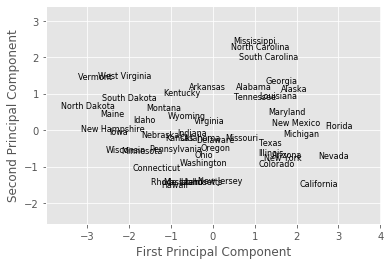

In [46]:
fig,ax1 = plt.subplots()

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)

for i,name in enumerate(PCframe['State'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=8)

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.show()

Explained Variance Ratio:  [0.62006039 0.24744129 0.0891408  0.04335752]


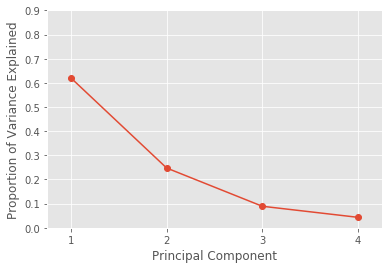

In [47]:
var_ratio = pca_model.explained_variance_ratio_
print("Explained Variance Ratio: ",var_ratio)

plt.plot([1,2,3,4], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,.9)
plt.xticks([1,2,3,4])
plt.show()

**Your description:** According to the explained variance ratio, about 86% of the data can be explained using the first two principle components. This is a high ratio so it is somewhat reasonable to take the 4 dimensional data down to two dimensions for analysis. Obviously it would be better if the first two components explained MORE of the data, but 86% is quite a high ratio.


### Task 1.4 k-means cluster analysis

1. Using k-means, cluster the states into four clusters. Use the scaled dataset. Which states belong to which clusters?
+ Vary k and find the *best* value. Describe wow do you determine *best*? 
+ Use the principal components to plot the best clustering. Again label each point using the state name and this time color the states according to the clustering. Is the PCA plot consistent with the clustering?


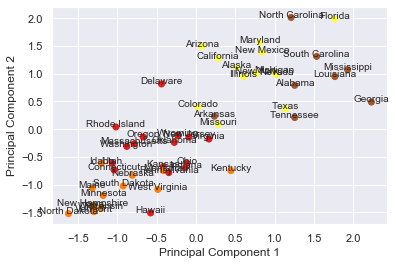

In [16]:
# Your code here
from matplotlib.colors import ListedColormap
fig,ax1 = plt.subplots()
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])
y_pred = KMeans(n_clusters=4).fit_predict(X)
for i,name in enumerate(PCframe['State'].values):
    ax1.annotate(name, (X[i,0], X[i,1]), ha='center',fontsize=10)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=cmap)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

For n_clusters = 2 The silhouette_score is : 0.4084890326217641


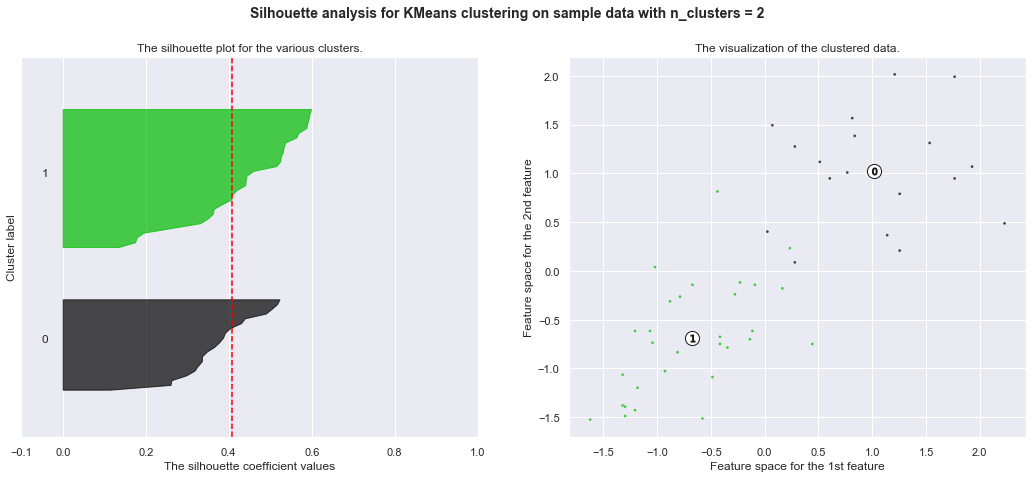

For n_clusters = 3 The silhouette_score is : 0.30813622648945616


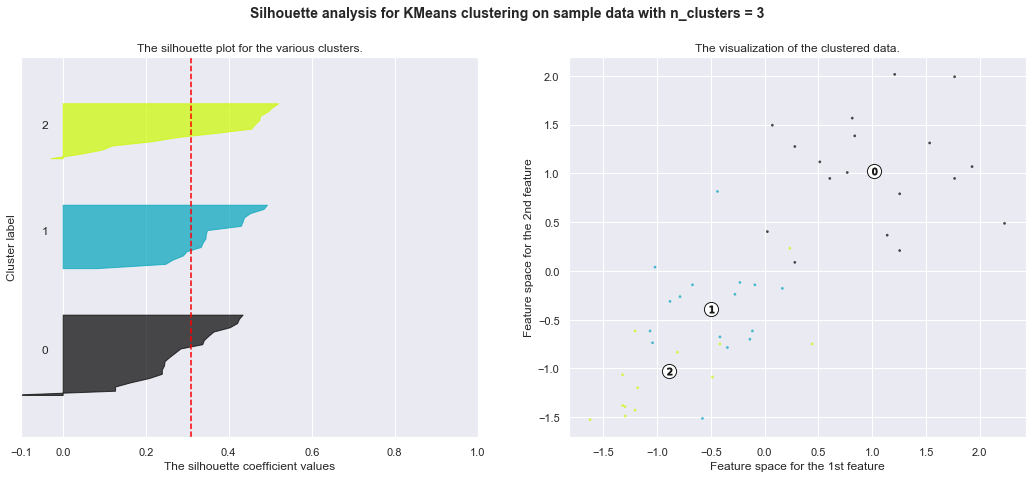

For n_clusters = 4 The silhouette_score is : 0.33968891433344395


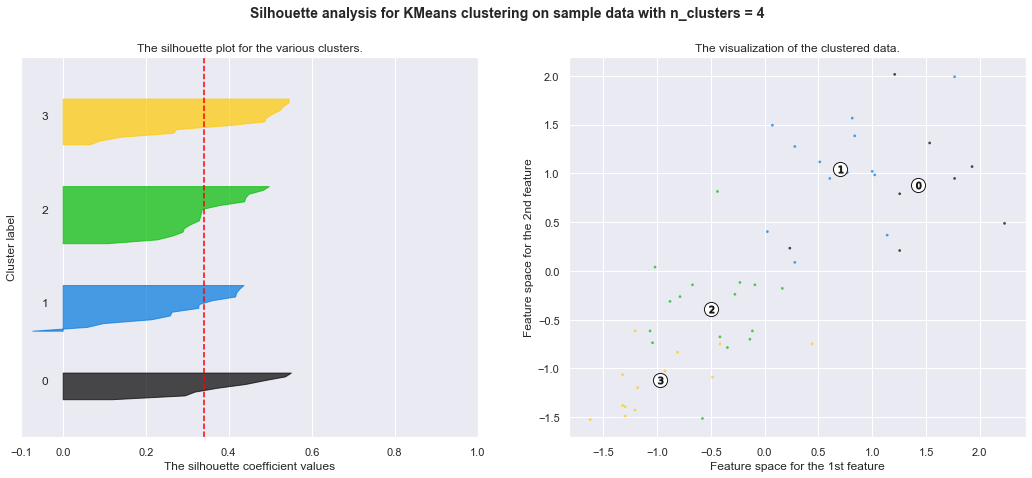

For n_clusters = 5 The silhouette_score is : 0.3133544326927289


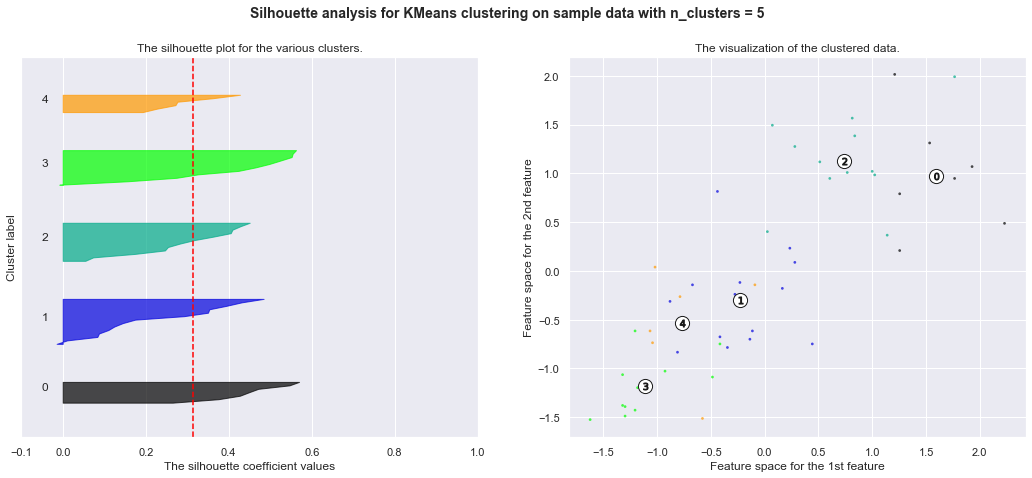

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [2,3,4,5]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

**Interpretation for best K:** The best k is 2, using the silhouette analysis.

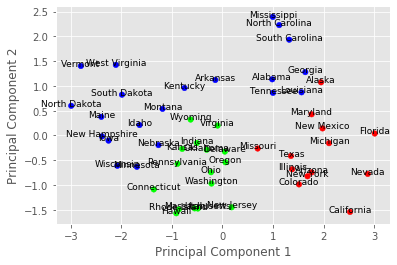

In [48]:
# your code here
##from sklearn.metrics import homogeneity_score
fig,ax1 = plt.subplots()
y_pred2 = KMeans(n_clusters=4).fit_predict(X)
for i,name in enumerate(PCframe['State'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=9)

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred2, cmap=cmap_bold,s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

**Interpretation for PCA and K-Means**: This K-Means using the clustering of two is not entirely accurate to the original PCA done in the previous section, but it is the most similar to the structure of the PCA in the previous section out of the k-values I tested. As shown in the silhouette scores for each of the k values, the maximum silhouette score is .40

### Task 1.5 Hierarchical cluster analysis

1.  Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states into four clusters. Which states belong to which clusters? 
2. Visualize your cluster results on top of the first two principle components, as before.
3. Do you get similar results as for k-means? Can you see trends between the states?

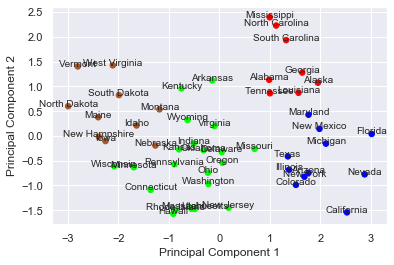

In [19]:
# Your code here
fig,ax1 = plt.subplots()

cluster_model = AgglomerativeClustering(linkage="complete", affinity='euclidean', n_clusters=4)
y_pred1 = cluster_model.fit_predict(X)
for i,name in enumerate(PCframe['State'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#a65628'])
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred1, cmap=cmap_bold,s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

**Interpretation:** I got similar results to my KMeans PCA model. There is a trend that is in the red cluster, where the states with high ratios in the first two components tend to be located in the Southern US (i.e. Alabama, Mississippi, and Georgia). States with low populations tend to belong to the Brown cluster (Vermont, South Dakota, Maine, etc.). States with high populations  belong in the blue category, and other states near the national average for both principal components belong to the green category.

### Task 1.6 DBSCAN

1.  Using DBSCAN and experiment with different values for $\epsilon$ and min samples. Which states belong to which clusters? 
2. Visualize your cluster results on top of the first two principle components, as before.
3. Do you get similar results as before? Is DBSCAN stable or very sensitive to changes in epsilon for this dataset?

Estimated number of clusters: 4
Estimated number of noise points: 10


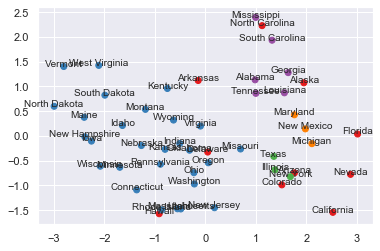

In [46]:
# Your code here
#clustering = DBSCAN(eps=4, min_samples=2).fit(X)
fig,ax1 = plt.subplots()
db_model = DBSCAN(eps=1.0, min_samples=2)
db_model.fit(X)
y_pred = db_model.fit_predict(X)
for i,name in enumerate(PCframe['State'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred,  marker="o", cmap=cmap); 

labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 29


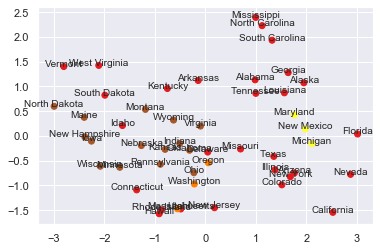

In [47]:
fig,ax1 = plt.subplots()
db_model2 = DBSCAN(eps=.75, min_samples=3)
db_model2.fit(X)
y_pred = db_model2.fit_predict(X)
for i,name in enumerate(PCframe['State'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred,  marker="o", cmap=cmap); 

labels = db_model2.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 23


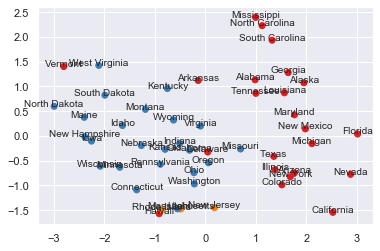

In [48]:
fig,ax1 = plt.subplots()
db_model3 = DBSCAN(eps=1, min_samples=5)
db_model3.fit(X)
y_pred = db_model3.fit_predict(X)
for i,name in enumerate(PCframe['State'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred,  marker="o", cmap=cmap); 

labels = db_model3.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

**Your Interpretation**: DBSCAN is very sensitive to epsilon changes. It is not a very stable way to analyze clusters as you have to hit the right epsilon to get a model worth looking at. I'm not getting super similar results compared to the other methods of clustering, but there are still patterns in the data. This includes Southern states still being grouped together quite often, in addition to states with lower populations being grouped together, as well as states with high populations being grouped together.

# 2. Regular Expressions 

Write regular expressions for the following examples that matches the data of the given format and any other reasonable variations thereof. E.g., your regex shouldn't be specific to one URL or one phone number, but should work for all examples of the same format.

**Task 2.1.** Writes a regular expression that extracts the urls out of this string, but only the URLs.

In [84]:
text1 = """To learn about pros/cons of data science, go to http://datascience.net.\
Alternatively, go to datascience.net/2018/"""
print(text1)

To learn about pros/cons of data science, go to http://datascience.net.Alternatively, go to datascience.net/2018/


In [86]:
# Your code here
urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text1)
print("Original string: ",text1)
print("Urls: ",urls)

Original string:  To learn about pros/cons of data science, go to http://datascience.net.Alternatively, go to datascience.net/2018/
Urls:  ['http://datascience.net.Alternatively,']


**Task 2.2.** Write a regular expression that extracts all phone numbers and fax numbers from this text: 

In [88]:
text2 = """You can reach me at 801-774-4321, or my office at (801) 223 9571 or (801) 223 2522.\ 
Send me a fax at 857 188 7422. We finally made the sale for all 977 giraffes.\
They wanted 225 957 dollars for it."""

In [90]:
# Your code here
text2 = """You can reach me at 801-774-4321, or my office at (801) 223 9571 or (801) 223 2522.\
Send me a fax at 857 188 7422. We finally made the sale for all 977 giraffes.\
They wanted 225 957 dollars for it."""
nums = re.findall(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]', text2)
print("Original string: ",text2)
print("numbers: ",nums)

Original string:  You can reach me at 801-774-4321, or my office at (801) 223 9571 or (801) 223 2522.Send me a fax at 857 188 7422. We finally made the sale for all 977 giraffes.They wanted 225 957 dollars for it.
numbers:  ['801-774-4321', '(801) 223 9571', '(801) 223 2522', '857 188 7422']


**Task 2.3.** Write a regular expression that extracts all opening html tags from this, including `<br />`.

In [ ]:
html = "This is <b>important</b> and <u>very</u><i>timely</i><br />. Was this <span> what you meant?</span>"

In [91]:
# Your code here
text3 = "This is <b>important</b> and <u>very</u><i>timely</i><br />. Was this <span> what you meant?</span>"
nums = re.findall(r'<([a-zA-Z]+)((.(?!</)(?!<[a-zA-Z]))*?[^?])?>', text3)
print("Original string: ",text3)
print("tags: ",nums)

Original string:  This is <b>important</b> and <u>very</u><i>timely</i><br />. Was this <span> what you meant?</span>
tags:  [('b', '', ''), ('u', '', ''), ('i', '', ''), ('br', ' /', ' '), ('span', '', '')]


**Task 2.4.** Write a regular expression that extracts all the names of people from the following text. 

In [92]:
text4 = """Arnold Schwarzenegger was born in Austria. He and Sylvester Stalone used to run a restaurant\
with J. Edgar Hoover."""

In [93]:
# Your code here
text4 = """Arnold Schwarzenegger was born in Austria. He and Sylvester Stalone used to run a restaurant\
with J. Edgar Hoover."""
names = re.findall(r'([A-Z][a-z]+(?: [A-Z][a-z]\.)? [A-Z][a-z]+)', text4)
print("Original string: ",text4)
print("names: ",names)

Original string:  Arnold Schwarzenegger was born in Austria. He and Sylvester Stalone used to run a restaurantwith J. Edgar Hoover.
names:  ['Arnold Schwarzenegger', 'Sylvester Stalone', 'Edgar Hoover']


**Task 2.5.** Write a regular expression that extracts the text out of all html elements of class important.

In [94]:
text4 = """Lorem ipsum dolor <b>sit</b> amet, <b class="important">consectetur adipiscing</b> elit,\ 
sed do eiusmod <span id="note">tempor incididunt ut</span> <div>labore <strong class="important">\
et dolore magna</strong> aliqua.</div> Ut enim ad minim veniam, quis nostrud exercitation ullamco."""

In [97]:
# Your code here
text5 = """Lorem ipsum dolor <b>sit</b> amet, <b class="important">consectetur adipiscing</b> elit,\
sed do eiusmod <span id="note">tempor incididunt ut</span> <div>labore <strong class="important">\
et dolore magna</strong> aliqua.</div> Ut enim ad minim veniam, quis nostrud exercitation ullamco."""
val1 = re.findall(r'(<b class="important".*?>)(.*?)(</b>)', text5)
#print("Original string: ",text5)
print("val1: ",val1)
val2 = re.findall(r'(<strong class="important".*>)(.*?)(</strong>)', text5)
#print("Original string: ",text5)
print("val2: ",val2)
print(val1,val2)

val1:  [('<b class="important">', 'consectetur adipiscing', '</b>')]
val2:  [('<strong class="important">', 'et dolore magna', '</strong>')]
[('<b class="important">', 'consectetur adipiscing', '</b>')] [('<strong class="important">', 'et dolore magna', '</strong>')]


## 3. NLP: Classifying Newsgroups Articles

Newsgroups were the social media of the 90s. Newsgroups are open discussion forums structured into hierarchies. For example, the following newsgroups cover topics as divers as atheism, computer graphics, and classified ads.  

```
alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
```

We will be combining machine learning and natural language processing to classify the news articles into these groups. We expect, for example, that the text for a classified ad in `misc.forsale` is different from text in `alt.atheism`. 

We will use the 20 Newsgroups corpus from scikit-learn. The 20 newsgroups dataset comprises around 18,000 newsgroups posts on 20 topics. The general steps we follow are:
1. Load the corpus    
+ Do preprocessing: removal of stopwords, stemming, etc.
+ Vectorize the text
+ Split into training and test sets
+ Train our classifier

Refer to documentation on the [20 newsgroups dataset](https://scikit-learn.org/stable/datasets/index.html#the-20-newsgroups-text-dataset) to learn about the dataset and find out how to download it.
We recommended you use the `subset='all'` parameter to load all the data at once, instead of `subset='train'` and `subset='test'` separately.

**Task 3.1.** Load the dataset.

1. Print the exact number of news articles in the corpus.
2. Print all 20 categories the news articles belong to.

In [60]:
# Your code here
from sklearn.datasets import fetch_20newsgroups
groups = fetch_20newsgroups(subset='all')

In [61]:
print("Number of articles: " + str(len(groups.data)))
print("Categories: ",list(groups.target_names))

Number of articles: 18846
Categories:  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### Task 3.2 Classification

Vectorize the data using vectorizers from sklearn. Using these vectors as features and the article category from corpus as labels, train a NaiveBayes classifier to classify the data.

#### Vectorizers

Vectorizes help us to transform text data into features we can use in machine learning. We did the vectorization manually in class, here you will use pre-build vectorizers. 

You should use CountVectorizer and TfidfVectorizer vectorizers from sklearn to vectorize your data. Please refer to documentation on both to learn how to use them.
+ http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
+ http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Compare the performance of classifiers using both vectorizers. You are encouraged to experiment with different parameters like max_df, min_df, etc. See docs for the meanings.

#### Naive Bayes
**Resources**
1. https://en.wikipedia.org/wiki/Naive_Bayes_classifier
2. https://www.geeksforgeeks.org/naive-bayes-classifiers
3. http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

We will be using Multinomial Naive Bayes from sklearn. Refer to documentation above for how to import the classifier. Then it can be used like any other classifier by using fit and predict functions provided on it.
e.g:

```
clf = MulitnomialNB(alpha = 1)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
```

Alpha is also known as the smoothing factor and ranges from 0 (no smoothing) to 1 (Laplace Smoothing). You can experiment with different values to see if you get better results. 

In [62]:
# Your code here
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [68]:
vect1 = TfidfVectorizer()
X11 = vect1.fit_transform(groups.data)
y11 = groups.target
clf = MultinomialNB(alpha = .1)
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X11, y11, test_size=0.2, random_state=11)
clf.fit(Xtrain1, ytrain1)
y_pred = clf.predict(Xtest1)
score1 = clf.score(Xtest1, ytest1)
print("Accuracy: ",score1)

Accuracy:  0.9029177718832891


In [67]:
vect2 = CountVectorizer()
X12 = vect2.fit_transform(groups.data)
y12 = groups.target
clf = MultinomialNB(alpha = .0001)
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X12, y12, test_size=0.2, random_state=11)
clf.fit(Xtrain2, ytrain2)
y_pred = clf.predict(Xtest2)
score2 = clf.score(Xtest2, ytest2)
print("Accuracy: ",score2)

Accuracy:  0.9005305039787799


### Task 3.3 Removing Stopwords

Now we'll use the NLTK stopword list to improve our data vectors. TfidfVectorizer and CountVectorizer both can take an argument called stop_words. The words passed to this argument are considered as stopwords and are not vectorized. Use the stopwords list from NLTK and pass it to vectorizers. Then evaluate the new vectors using Multinomial Naive Bayes.

Answer the following questions:
1. How much accuracy would a naive approach, that picks one of the 20 categories at random achieve?
1. What accuracy were you able to achieve? 
1. What was the influence of the different vectorizers and the stopword removal? 



In [22]:
# Your code here
from nltk.corpus import stopwords

In [69]:
data2 = groups.data
target2 = groups.target
def stopword(classif,X1,y1):
    Xtrain3,Xtest3,ytrain3,ytest3= train_test_split(X1,y1,test_size=0.2, random_state=11)
    classif.fit(Xtrain3,ytrain3)
    y_pred = classif.predict(Xtest3)
    score3 = classif.score(Xtest3,ytest3)
    print("Accuracy: ", score3)
    return classif

In [70]:
trialrun = Pipeline([ ('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),('classifier', MultinomialNB())])
stopword(trialrun,data2,target2)

Accuracy:  0.8806366047745358


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves'...
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                   

In [21]:
trialrun2 = Pipeline([ ('vectorizer', CountVectorizer(stop_words=stopwords.words('english'))),('classifier', MultinomialNB())])
stopword(trialrun2, data2, target2)

Accuracy: 0.8729442970822281


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself

In [72]:
rand = fetch_20newsgroups(subset='train', shuffle=True)

vect1 = CountVectorizer()
trainingcount = vect1.fit_transform(rand.data)
trainingcount.shape

tftransformer = TfidfTransformer()
trainingtfidf = tftransformer.fit_transform(trainingcount)
trainingtfidf.shape
clf2 = MultinomialNB().fit(trainingtfidf, rand.target)
txtclf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])
txtxclf = txtclf.fit(rand.data, rand.target)

randtest = fetch_20newsgroups(subset='test', shuffle=True)
predicted = txtclf.predict(randtest.data)
print("Random Category Accuracy: ", np.mean(predicted == randtest.target))

Random Category Accuracy:  0.7738980350504514


**Interpretation:** For the higher accuracy, the TfidTransformer had higher accuracy, with 88%, having the random caterogy selected resulted in an accuracy of 77%, and the CountVectorizer sat just underneath the TfidTransformer with 87% accuracy. So my highest accuracy was 88% and the CountVectorizer is less accurate than the TfidTransformer, and the random Naive test had the lowest accuracy of all at 77%.